# Project: Predicting Diabetes

# Step 1: Import Essential Libraries 

In [1]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.feature_selection import f_regression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree


# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem

    This dataset originally comes from the National Institute of Diabetes and Digestive and Kidney Diseases. The goal is to predict, based on diagnostic measures, whether or not a patient has diabetes.


## 2.2 Inicitial Loading and Inspection

In [2]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=421&path=diabetes.csv"
TARGET_FILE = "diabetes.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/diabetes.csv


True

In [3]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
    print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0

# Step 3: Exploration and Data Cleaning
    - Pregnancies. Number of pregnancies of the patient (numeric)
    - Glucose. Plasma glucose concentration 2 hours after an oral glucose tolerance test (numeric)
    - BloodPressure. Diastolic blood pressure (measured in mm Hg) (numeric)
    - SkinThickness. Triceps skin fold thickness (measured in mm) (numeric)
    - Insulin. 2-hour serum insulin (measured in mu U/ml) (numeric)
    - BMI. Body mass index (numeric)
    - DiabetesPedigreeFunction. Diabetes Pedigree Function (numeric)
    - Age. Age of patient (numeric)
    - Outcome. Class variable (0 or 1), being 0 negative in diabetes and 1 positive (numeric)

## 3.1 DataSet Dimension & Tipology Visibility

In [4]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 768 number of rows and 9 columns.


## 3.2 Top 5 Row View

In [5]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |             

## 3.3 Data Types and Non-Nulls Values Overview.

In [6]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info(max_cols= 108))

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


## 3.4 Check Unique

In [7]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


### 3.4.1 Conclusions about the data info:
- There is a total of 768 rows and 9 columns.
- INTEGER Dtype are 7 int64 columns.
- FLOAT Dtype are 2 float64.
- OBJECT Dtype are 0 str.
### Non-Null checking:
- int64: 100% ok.
- float64: 100% ok.

## 3.5 Check for Duplicates Values

In [8]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"There is << {duplicate_val} >> duplicated value in the dataset.")

There is << 0 >> duplicated value in the dataset.


## 3.6 Duplicates Inspection

In [9]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows:\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows:
+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
| Pregnancies   | Glucose   | BloodPressure   | SkinThickness   | Insulin   | BMI   | DiabetesPedigreeFunction   | Age   | Outcome   |
|---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+


## 3.7 Drop Duplicates

In [10]:
df = df.drop_duplicates().reset_index(drop= True)
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(768, 9)
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

## 3.8 Eliminate Irrelevant Information

- It is very difficult at first glance to determine what varibale is irrlevant.
- So I will run an analysis involving a first correlation list and a heatmap between the numerical variable and start depurating the list.

In [11]:
# 1. Drop identifiers that don't help the math
# We keep the numeric columns and drop unique text strings
df_numeric = df.select_dtypes(include=[np.number])

# 2. Let's assume 'Outcome' is our target (y)
# Let's check the top correlations to confirm
target = 'Outcome' 

if target in df_numeric.columns:
    correlations = df_numeric.corr()[target].sort_values(ascending=False)
    print("--- Top Correlations with Target ---")
    print(tabulate(pd.DataFrame(correlations), headers= "keys", tablefmt= "psql"))
else:
    print(f"Target '{target}' not found. Please check df.columns for the exact name.")

--- Top Correlations with Target ---
+--------------------------+-----------+
|                          |   Outcome |
|--------------------------+-----------|
| Outcome                  | 1         |
| Glucose                  | 0.466581  |
| BMI                      | 0.292695  |
| Age                      | 0.238356  |
| Pregnancies              | 0.221898  |
| DiabetesPedigreeFunction | 0.173844  |
| Insulin                  | 0.130548  |
| SkinThickness            | 0.0747522 |
| BloodPressure            | 0.0650684 |
+--------------------------+-----------+


Zero counts per column:
Glucose: 5 zeros
BloodPressure: 35 zeros
SkinThickness: 227 zeros
Insulin: 374 zeros
BMI: 11 zeros


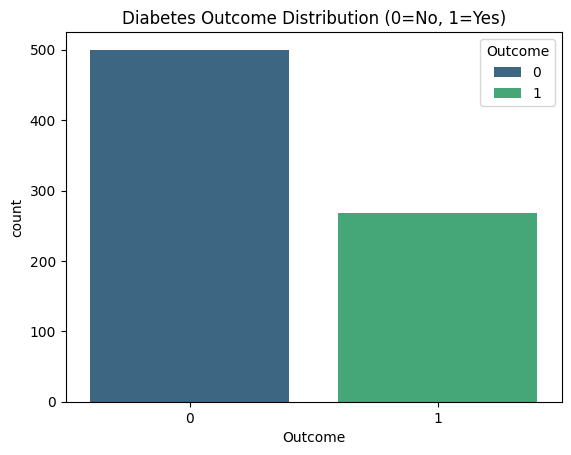

In [12]:
# 1. Check for 'Hidden' missing values
# Columns where a 0 is biologically impossible
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Zero counts per column:")
for col in cols_to_fix:
    print(f"{col}: {(df[col] == 0).sum()} zeros")

# 2. Visualize the Class Imbalance (Target)
sns.countplot(x='Outcome', data=df, hue= 'Outcome', palette='viridis')
plt.title('Diabetes Outcome Distribution (0=No, 1=Yes)')
plt.show()

In [13]:
# Inecessary columns. I will drop them.
drop_cols = ['BloodPressure', 'SkinThickness', 'Insulin']
df = df.drop(columns= drop_cols)
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+---------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |  28.1 |                      0.167 |    21 |         0 |
|  4 |             0 |       137 |  43.1 |                      2.288 |    33 |         1 |
+----+---------------+-----------+-------+----------------------------+-------+-----------+


### 3.8.1 Conclusion about Columns Dropping
- **SkinThickness**: With 227 zeros, we were missing almost 30% of the data. Plus, as the correlation table showed, it had a very weak relationship with the outcome (0.07).
- **BloodPressure**: While 35 zeros isn't a lot, Blood Pressure is notoriously "noisy" in this dataset. Many people have high blood pressure without having diabetes, making it a poor "discriminator" for a Decision Tree.
- **Insulin**: Even though insulin is biologically linked to diabetes, having 374 zeros (nearly 50% of the data) meant that any "imputed" values would have been more "fake" than "real."

# Step 4: Analysis of Univariate Variables
## 4.1 Categorical Variable Analysis

In [14]:
# Select only columns with 'object' or 'str' data type (strings/categories)
categorical_val = df.select_dtypes(include= ['str']).columns.tolist()
if len(categorical_val) != 0:
    print(f"Categorical Variables: {categorical_val}")
else:
    print(f"There are not visible variable for categorical analysis")

There are not visible variable for categorical analysis


* In this case as the target is numerical, the code above is will not detect that this is actually a categorical variable, the only one. "Outcome"

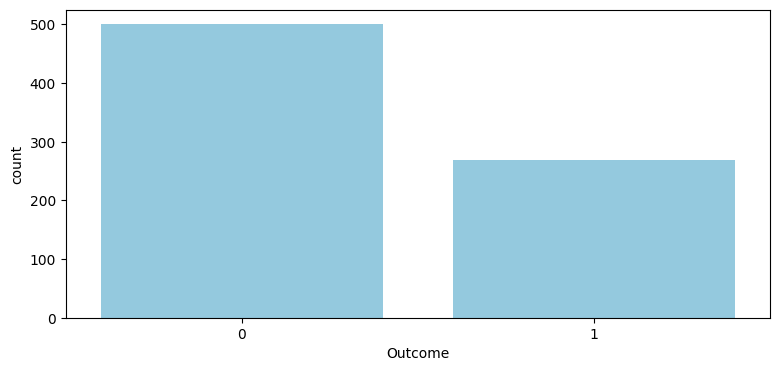

In [15]:
# Creating countplots for the categorical variables
# It is better to use countplot to visualize the behavior
# if len(categorical_val) != 0:
categorical_val = ['Outcome']
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize = (20, 4 * nrows))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    if i < len(axes_flat):
        sns.countplot(data = df, x= col,  ax = axes_flat[i], orient= 'v', color= "skyblue")
        axes_flat[i].tick_params(axis='x', rotation= 0)
    if i >= 1:
        axes_flat[i].set(ylabel= None)
    
    # Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# plt.tight_layout()
plt.show()
# else:
#    print(f"There are not categorical variable for this analysis")

### 4.1.1 Conclusions on Countplot for Categorical Variables
- The Ratio: we have roughly 500 negative cases compared to approximately 268 positive cases. This means about 65% of the dataset represents people without diabetes.

## 4.2 Numeric Variables Analysis

In [16]:
# Select only columns with 'int or float' data type (numeric
numerics = df.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


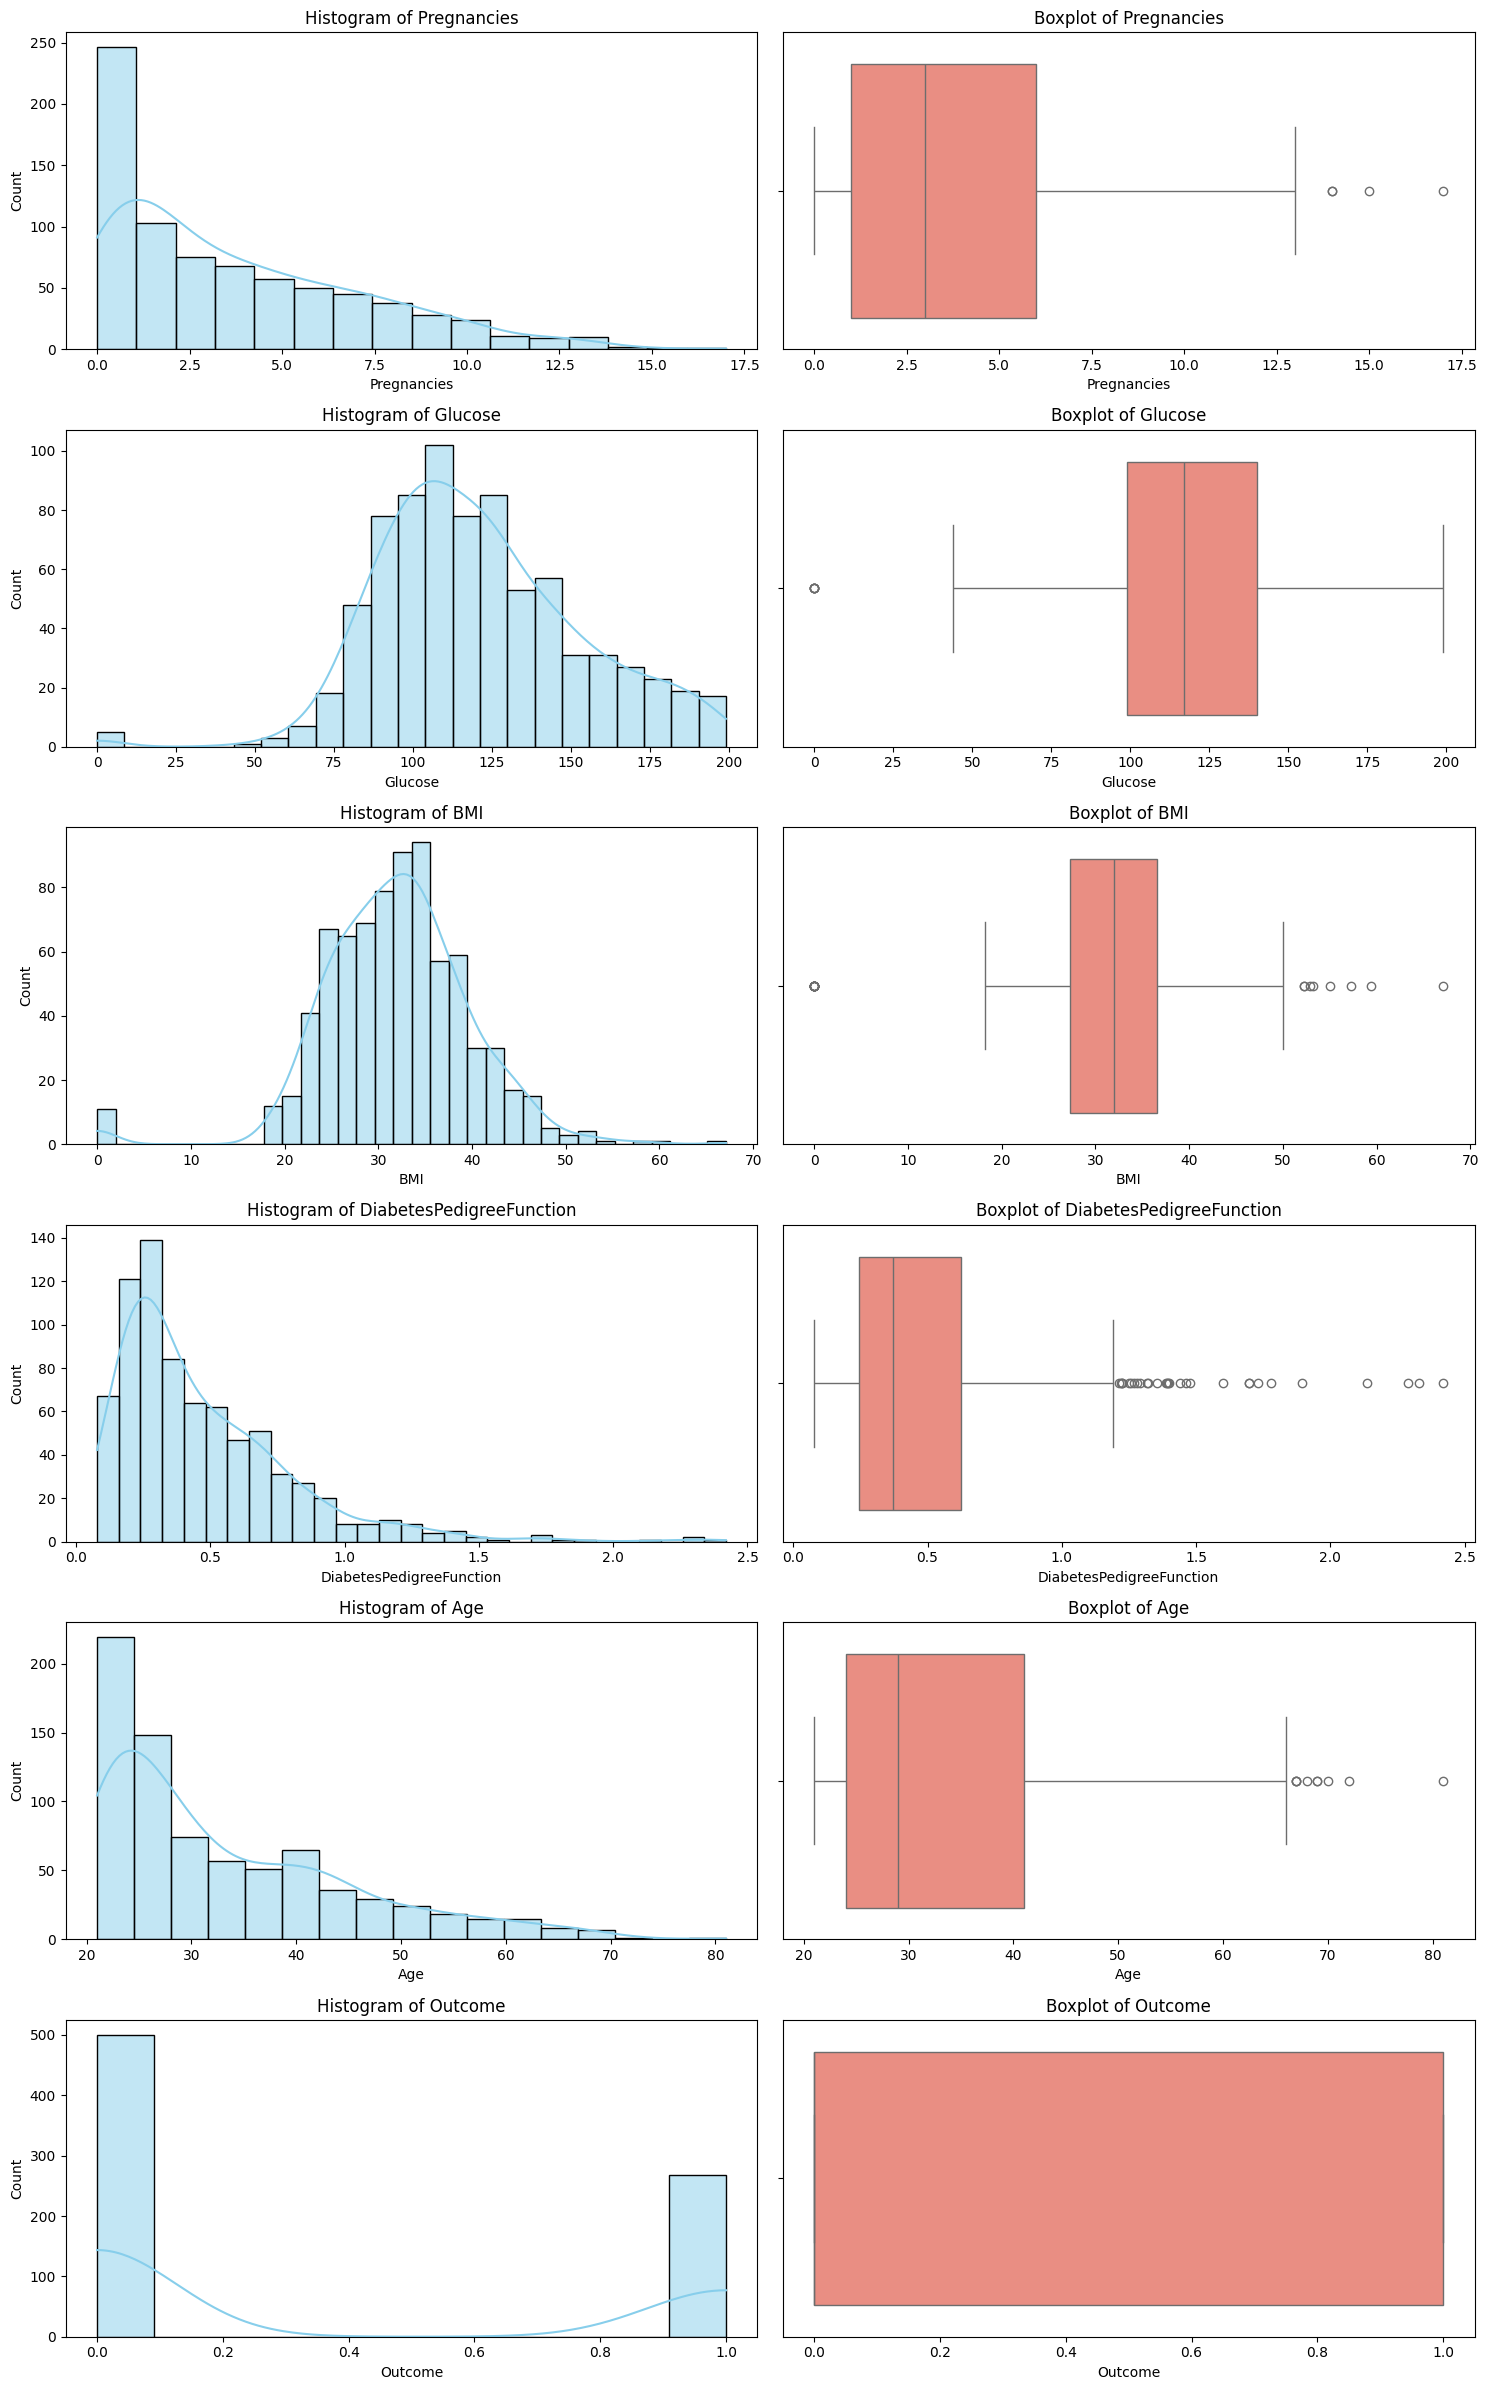

In [17]:
# Creating histplot and boxplot for the numeric variables
if len(numerics) != 0:
    nrows = len(numerics)
    ncols = 2
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(15, 4 * nrows))

    for i, col in enumerate(numerics):
        sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue")
        axes[i, 0].set_title(f'Histogram of {col}')
        sns.boxplot(x=df[col], ax=axes[i, 1], color="salmon")
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()
else:
    print("There are no numercial variables or the list numerics might be empty")

### 4.2.1 Conclusions for Numerical Variable Charts
1. The Histograms (Left Column): 
    - **Pregnancies and Age**: Both show a strong right-skewed distribution. Most patients are younger (20–40 years old) and have fewer pregnancies, with a long "tail" of older patients and those with many pregnancies.
    - **Glucose and BMI**: These features follow a more Normal (Gaussian) distribution. However, one can clearly see the "0" values spiking at the far left of the histograms for both, confirming they are outliers that need attention.
    - **DiabetesPedigreeFunction**: This also shows a heavy right skew, meaning most patients have a low genetic score, while a few have very high scores.
2. The Boxplots (Right Column)
    - High Outliers: Pregnancies, BMI, DiabetesPedigreeFunction, and Age all show significant outliers on the upper end (the dots past the right whisker).
    - The "Zero" Outliers: The boxplots for Glucose and BMI specifically highlight the low-end outliers at 0. Since these are biologically impossible, they are the most critical data points to clean before running the Decision Tree.
    - Outcome Check: The bottom histogram and boxplot for Outcome simply visualize the class imbalance we discussed—showing significantly more '0's than '1's.

# Step 5: Multivariate Variables Analysis
## 5.1 Numerical-Numerical Analysis

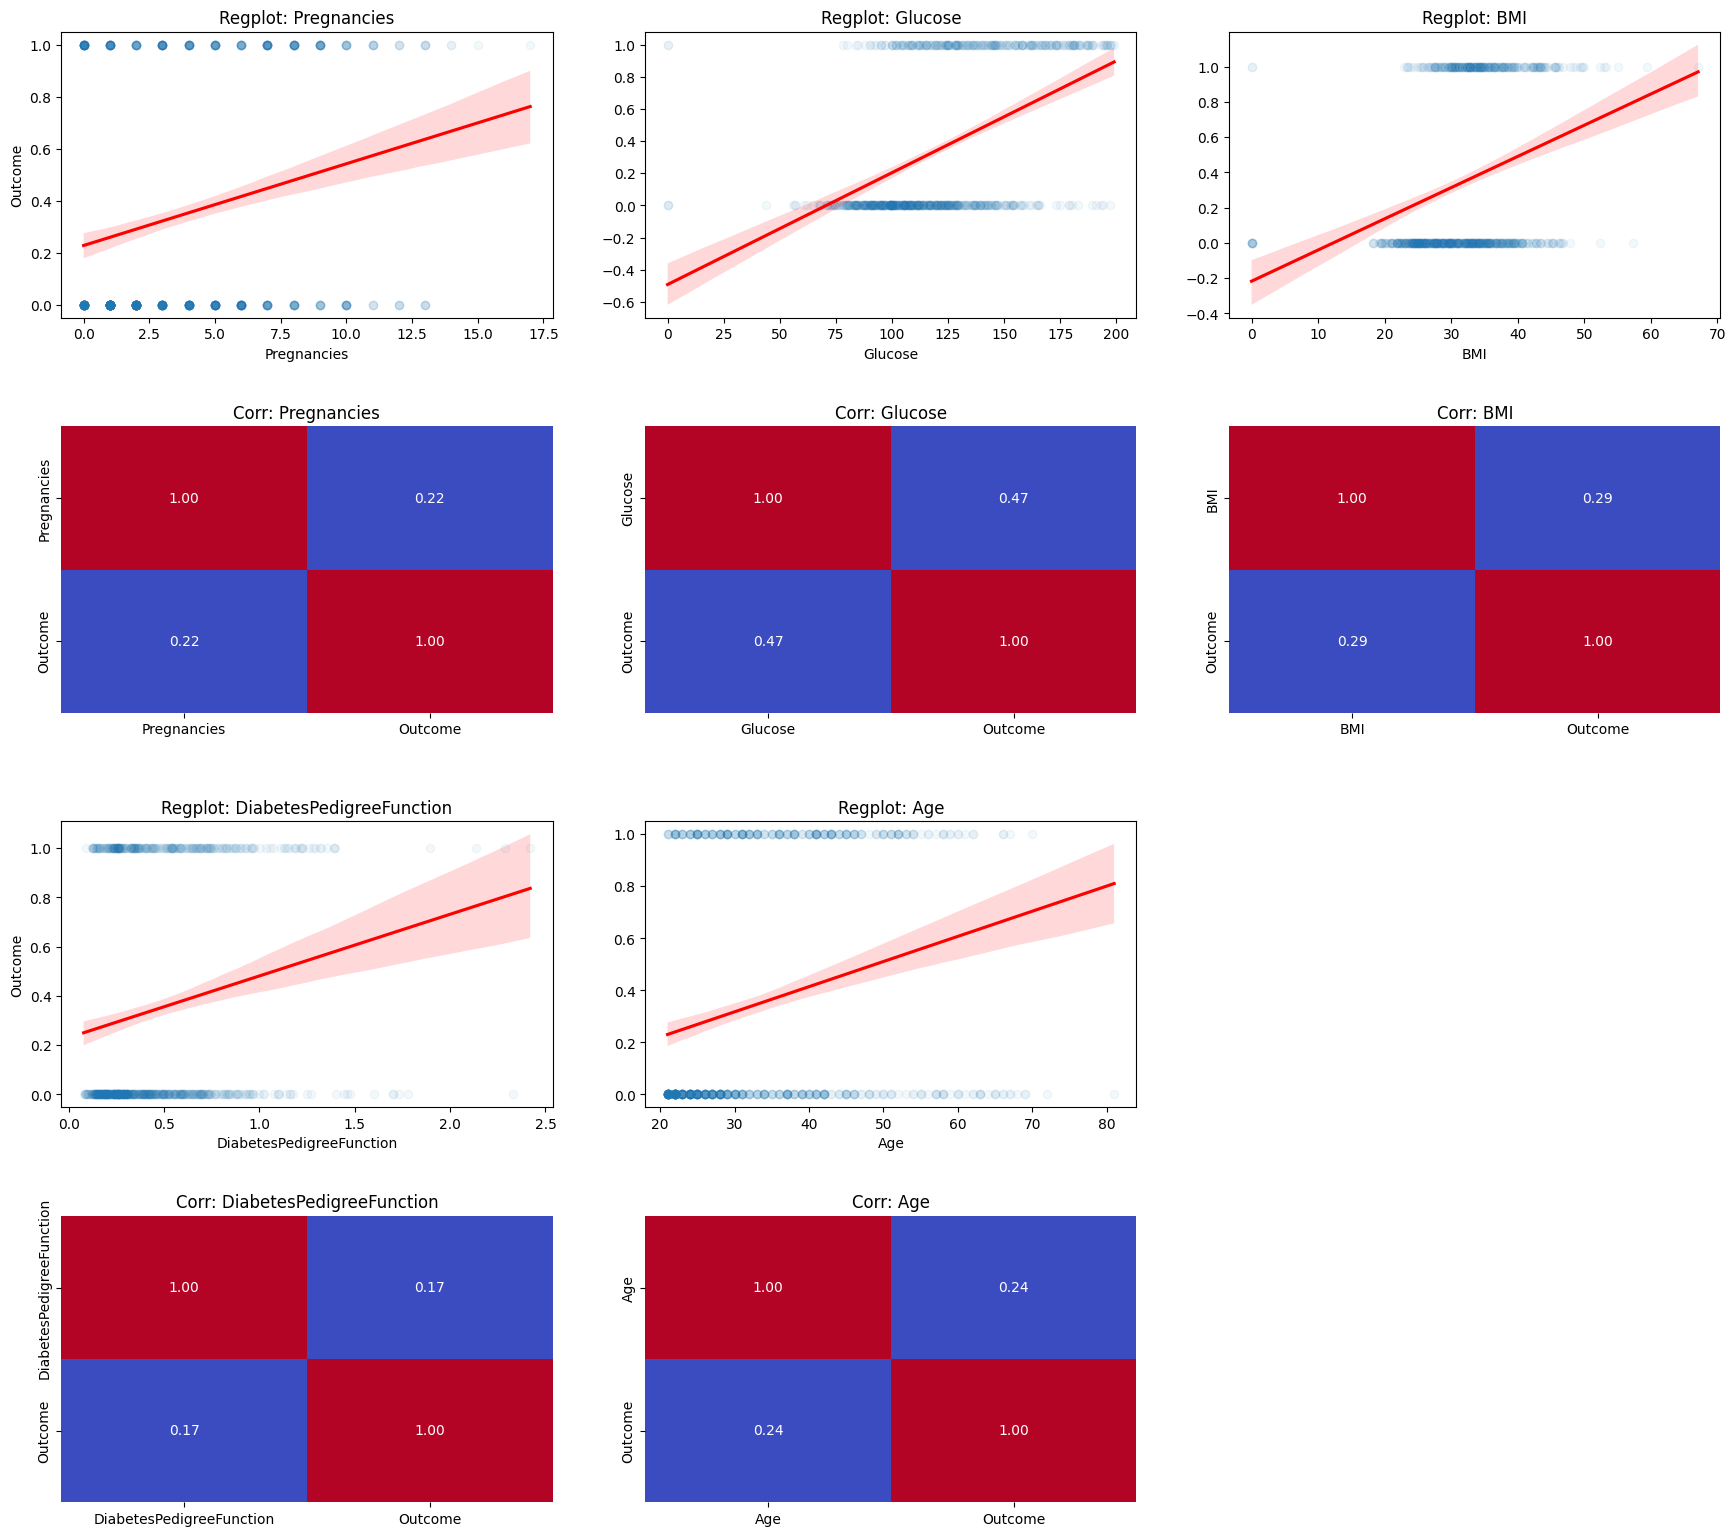

In [18]:
# 1. Excluding the target. The condition is to avoid ploting the target with itself.
if 'Outcome' in numerics: numerics.remove('Outcome')
target_num = 'Outcome'

# 2. Calculate Grid Size
ncols = 3
group_chart = math.ceil(len(numerics) / ncols)
nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))

for chart_idx in range(group_chart):
    # Determine which row we are on for Regplots
    reg_row = chart_idx * 2
    # The Heatmap row is always the one right below it
    heat_row = reg_row + 1

    # Get the 3 variables for this group
    start = chart_idx * ncols
    end = start + ncols
    current_vars = numerics[start:end]

    for col_idx, col in enumerate(current_vars):
        # --- Plot 1: Regplot ---
        sns.regplot(data= df, x= col, y= target_num, ax= axes[reg_row, col_idx], scatter_kws={'alpha':0.05}, line_kws={'color':'red'})
        axes[reg_row, col_idx].set_title(f'Regplot: {col}')
        if col_idx > 0:
            axes[reg_row, col_idx].set(ylabel= None)
        # --- Plot 2: Heatmap ---
        sns.heatmap(df[[col, target_num]].corr(), annot=True, fmt=".2f", ax=axes[heat_row, col_idx], cmap='coolwarm', cbar= False)
        axes[heat_row, col_idx].set_title(f'Corr: {col}')
# 4. Hide empty slots (if any)
for col_idx in range(len(current_vars), ncols):
    axes[reg_row, col_idx].set_visible(False)
    axes[heat_row, col_idx].set_visible(False)


plt.tight_layout(pad=3.0)
plt.show()

### 5.1.1 Conclusion Num-Num analysis
- **Glucose as the Primary Driver**: The Regplot for Glucose shows the steepest positive slope and the highest correlation coefficient (0.47) with the Outcome. This confirms it is the most influential numerical feature in your dataset.
- **Physical and Demographic Markers**: BMI (0.29), Age (0.24), and Pregnancies (0.22) all show moderate positive correlations. The regression lines clearly show that as these values increase, the probability of a positive diabetes Outcome also rises.
- **DiabetesPedigreeFunction**: has the weakest linear relationship among the top features, with a correlation of 0.17. While there is a positive trend, the data points are much more scattered.

## 5.2 Num - Num Analysis (other predictors)

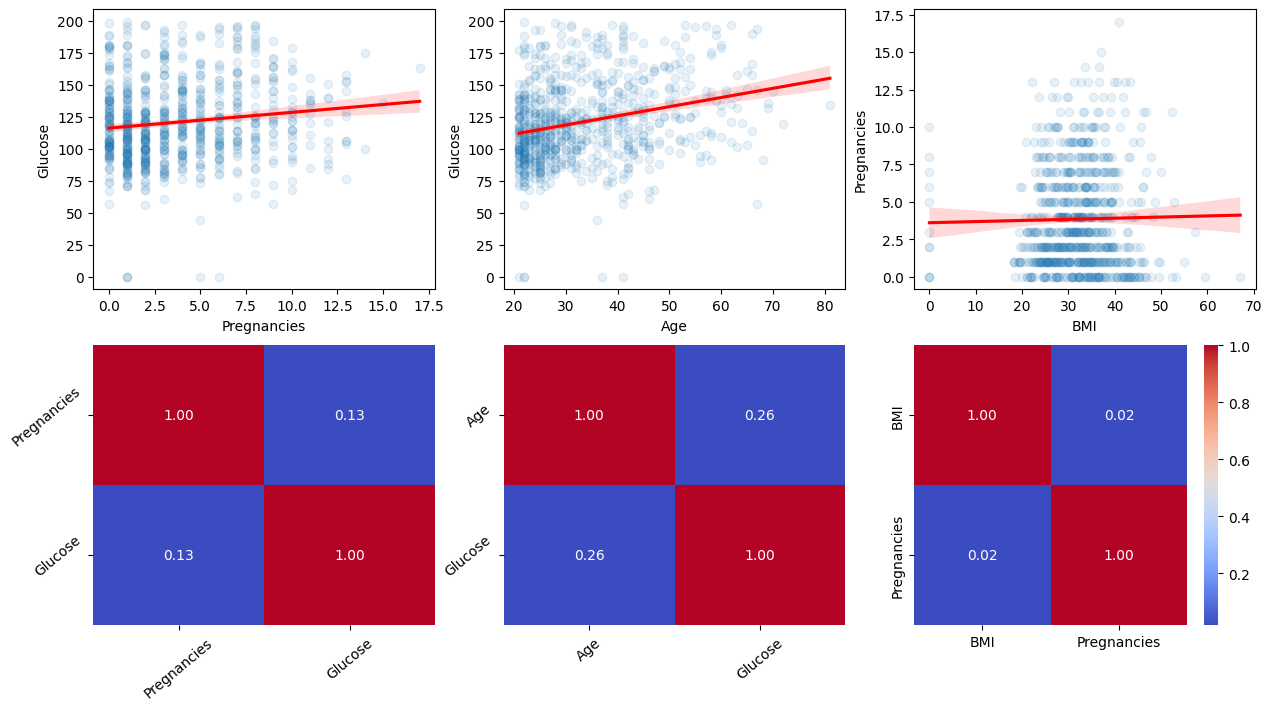

In [19]:
# A quick checking for Multicollinearity between two specific predictors
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(5 * ncols, 4 * nrows))

sns.regplot(data=df, ax=axes[0, 0], x='Pregnancies', y='Glucose', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['Pregnancies', 'Glucose']].corr(), annot=True, fmt=".2f", ax=axes[1, 0], cbar=False, cmap='coolwarm')
axes[1,0].tick_params(rotation= 40)

sns.regplot(data=df, ax=axes[0, 1], x='Age', y='Glucose', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['Age', 'Glucose']].corr(), annot=True, fmt=".2f", ax=axes[1, 1], cbar=False, cmap='coolwarm')
axes[1,1].tick_params(rotation= 40)

sns.regplot(data=df, ax=axes[0, 2], x='BMI', y='Pregnancies', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['BMI', 'Pregnancies']].corr(), annot=True, fmt=".2f", ax=axes[1, 2], cmap='coolwarm')
# axes[1,2].tick_params(rotation= 25)

# plt.tight_layout()
plt.show()

### 5.2.1 Conclusion Num-Num (others predictors)
- **Glucose and Age Connection**: There is a notable positive correlation (0.26) between Age and Glucose levels. The regression plot shows that as patients get older, their baseline glucose levels tend to rise.
- **Pregnancies and Glucose**: A weaker correlation (0.13) exists between the number of Pregnancies and Glucose. While there is a slight upward trend, the data is very scattered.
- **BMI vs. Pregnancies**: Interestingly, there is almost zero correlation (0.02) between BMI and the number of Pregnancies. The flat regression line indicates that in this dataset, a higher body mass index is not necessarily linked to having had more children.

In [20]:
categorical_val

['Outcome']

## 5.3 Categorical-Categorical Analysis

In [21]:
# Categorical Variables: ['Outcome']
categorical_length = len(categorical_val)
if categorical_length != 0 and 'Outcome' not in categorical_val:
    #if 'Outcome' in categorical_val: categorical_val.remove('Outcome')
    ncols = 3
    nrows = math.ceil(categorical_length / ncols)
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols , figsize = (20, 7))
    axes_flat = axes.flatten()

    for i, col in enumerate(categorical_val):
        sns.barplot(ax = axes_flat[i], data = df, x = 'Outcome', y= col, hue= col, palette='magma') # NOTE: in this project "X" and "Y" were inverted for better chart visibility
        axes_flat[i].tick_params(axis= 'x', rotation= 0)

    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No categorical variable for analysis. << Also check if the only one categorical is the target, then no analysis required >>.")

No categorical variable for analysis. << Also check if the only one categorical is the target, then no analysis required >>.


### 5.3.1 Conclusion Cat - Cat Analysis
- No need to do the analysis as there are not categorical variables but the target.

## 5.4 Combinations with Others Predictors
- No need to do the combination as we only have one categorical variable that is the targte 'Outcome'

## 5.5 Correlation / Factorize Analysis
No need to do any factorize method.

In [22]:
asking_if_factorize = input("Please confirm if you need to apply any factorize analysis for your variables with y/n:")
print(f"Your answer is: {asking_if_factorize}")

Your answer is: n


In [23]:
if asking_if_factorize == 'y':
    categorical_vars = [] # Input your categorical variables
    categorical_num = [var + '_num' for var in categorical_vars]
    # Categorical factorization
    for col in categorical_num:
        no_num_col = col[:-4]
        df[str(col)] = pd.factorize(df[no_num_col])[0]
    # Visibility of the last loop to see factorization
    print(tabulate(df[[no_num_col, col]].head(), headers='keys', tablefmt='psql'))
else:
    print("Factorize analysis is not necessary")

Factorize analysis is not necessary


## 5.6 Saving the JSON

In [24]:
# Save the json
if asking_if_factorize == 'y':
    prefix_name = '_transformation_rules'
    for col in categorical_num:
        no_num_col = col[:-4]
        file_name = no_num_col + prefix_name + ".json"
        factorized_dict = {row[no_num_col]: row[col] for index, row in df[[col, no_num_col]].drop_duplicates().iterrows()}

    with open("../data/interim/" + file_name, "w") as f:
        json.dump(factorized_dict, f)
else:
    print("As no factorize available, no need to save the json.")

As no factorize available, no need to save the json.


## 5.7 Num - Cat Analysis (Complete)

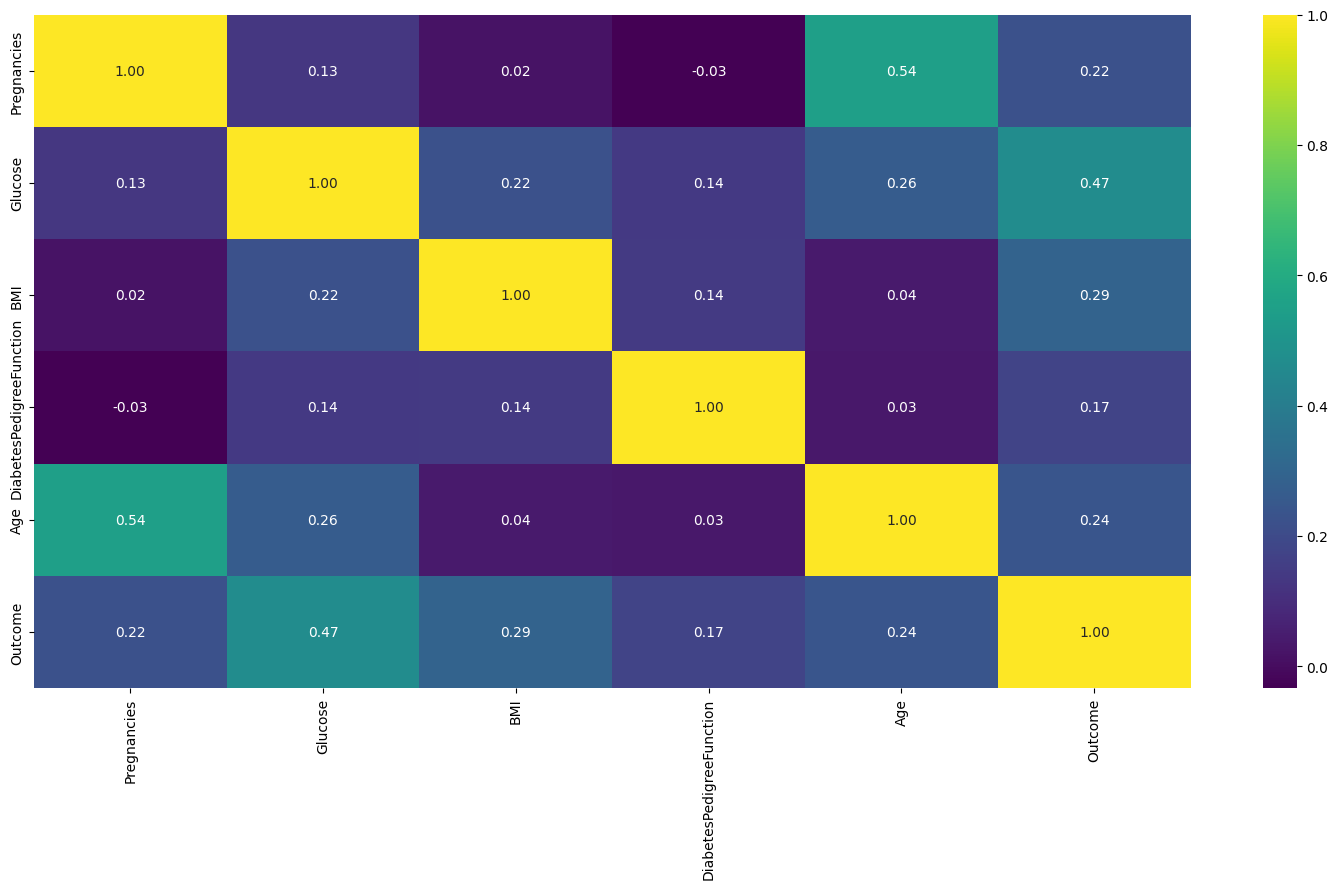

In [25]:
# Creating heatmap chart to analyze complete variables correlation
cols_num = df.select_dtypes(include= ['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "viridis", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()

### 5.7.1 Conclusion Correlation Heatmap

- **Glucose is the "Golden" Feature**: With a correlation of 0.47, Glucose remains the strongest individual predictor of diabetes.
- **Moderate Physical Markers**: BMI (0.29), Age (0.24), and Pregnancies (0.22) all show consistent, moderate positive correlations with Outcome.
- **Strongest Internal Relationship**: The highest correlation between two predictors is between Age and Pregnancies (0.54).
- **The Genetic Component**: DiabetesPedigreeFunction has a correlation of 0.17 with the Outcome. Interestingly, it has very low correlation with all other features (all 0.14 or lower).

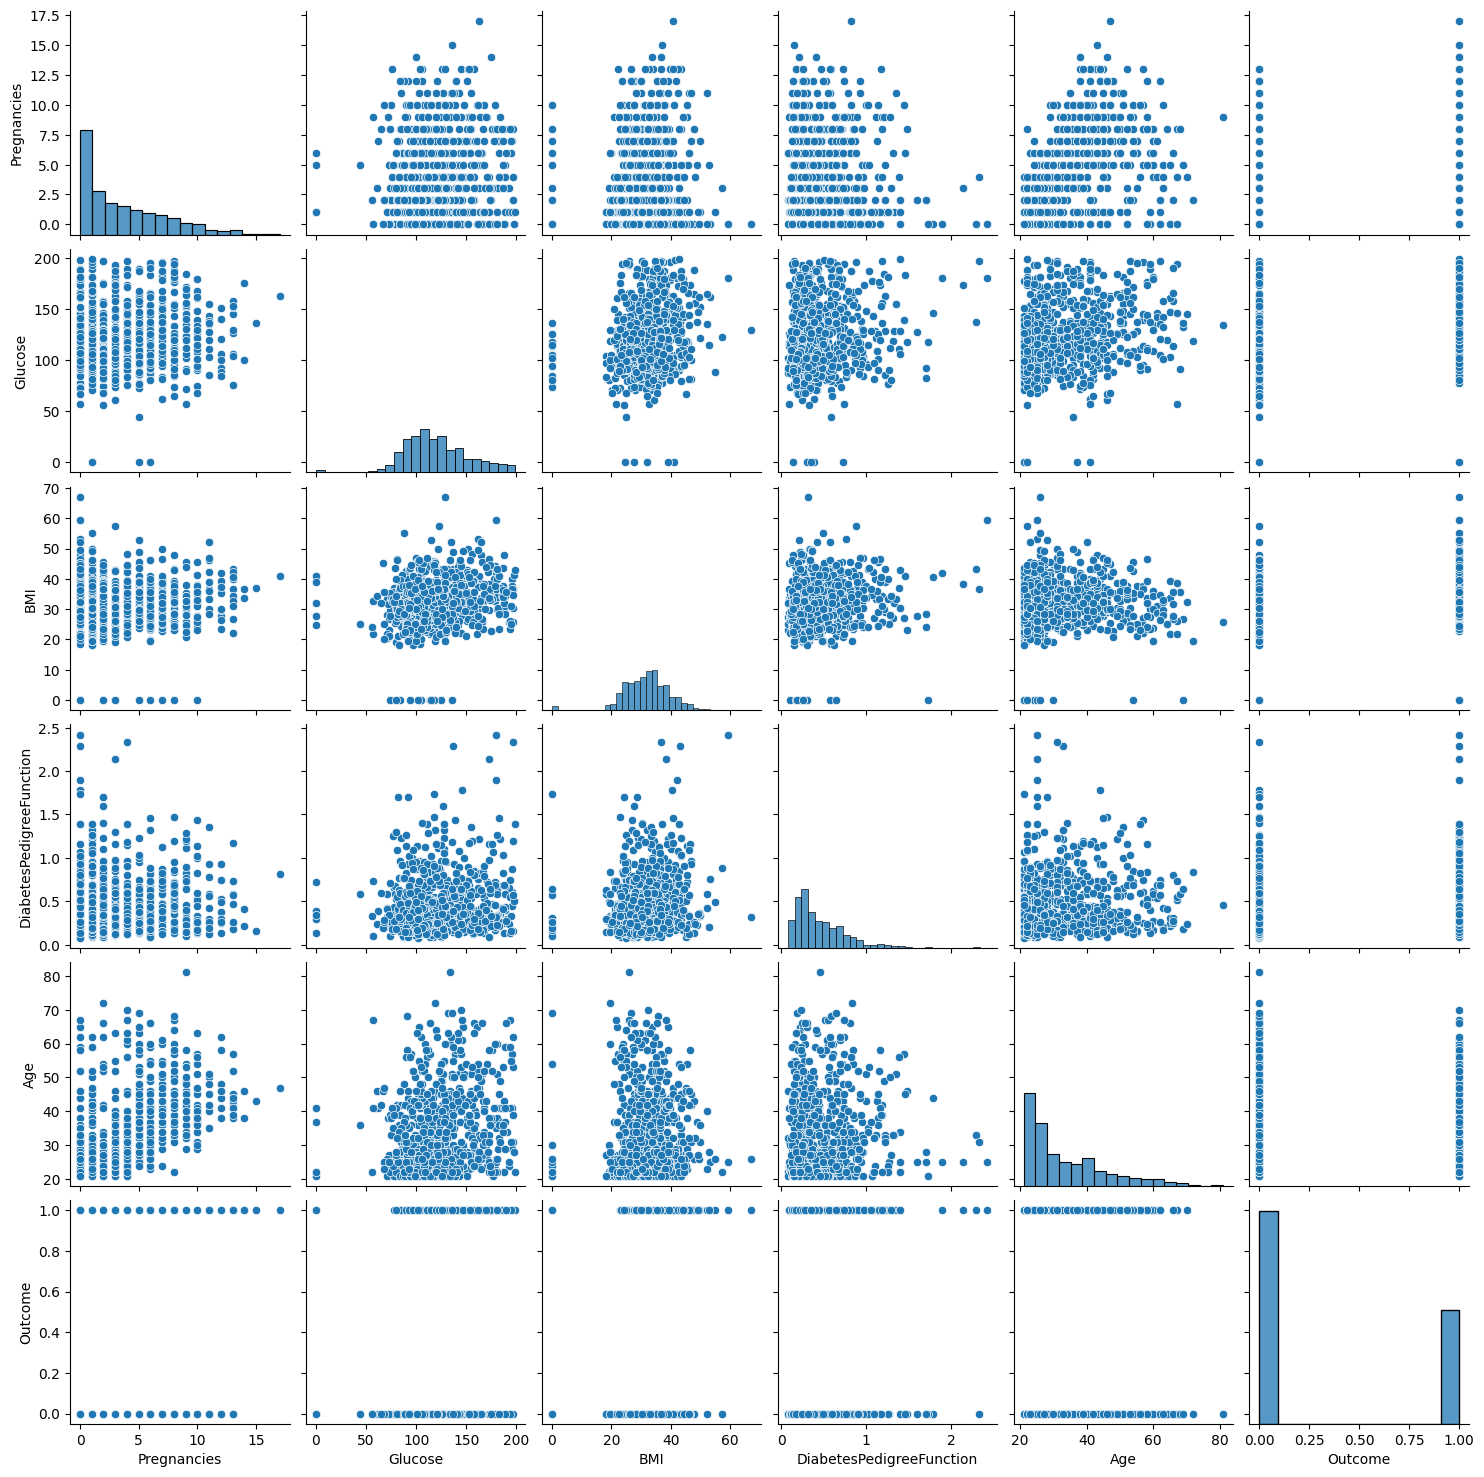

In [26]:
# Creating pairplot to have a variables behaviour visibility 
sns.pairplot(data= df)

## 5.8 Final DataSet Columns
FINAL_COLS = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']					


In [27]:
final_cols = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = df[final_cols]

In [28]:
print(tabulate(df.describe(), headers= "keys", tablefmt= "psql"))

+-------+---------------+-----------+-----------+----------------------------+----------+------------+
|       |   Pregnancies |   Glucose |       BMI |   DiabetesPedigreeFunction |      Age |    Outcome |
|-------+---------------+-----------+-----------+----------------------------+----------+------------|
| count |     768       |  768      | 768       |                 768        | 768      | 768        |
| mean  |       3.84505 |  120.895  |  31.9926  |                   0.471876 |  33.2409 |   0.348958 |
| std   |       3.36958 |   31.9726 |   7.88416 |                   0.331329 |  11.7602 |   0.476951 |
| min   |       0       |    0      |   0       |                   0.078    |  21      |   0        |
| 25%   |       1       |   99      |  27.3     |                   0.24375  |  24      |   0        |
| 50%   |       3       |  117      |  32       |                   0.3725   |  29      |   0        |
| 75%   |       6       |  140.25   |  36.6     |                   0.626

# Step 6: Feature Engineering
## 6.1 Outlier analysis

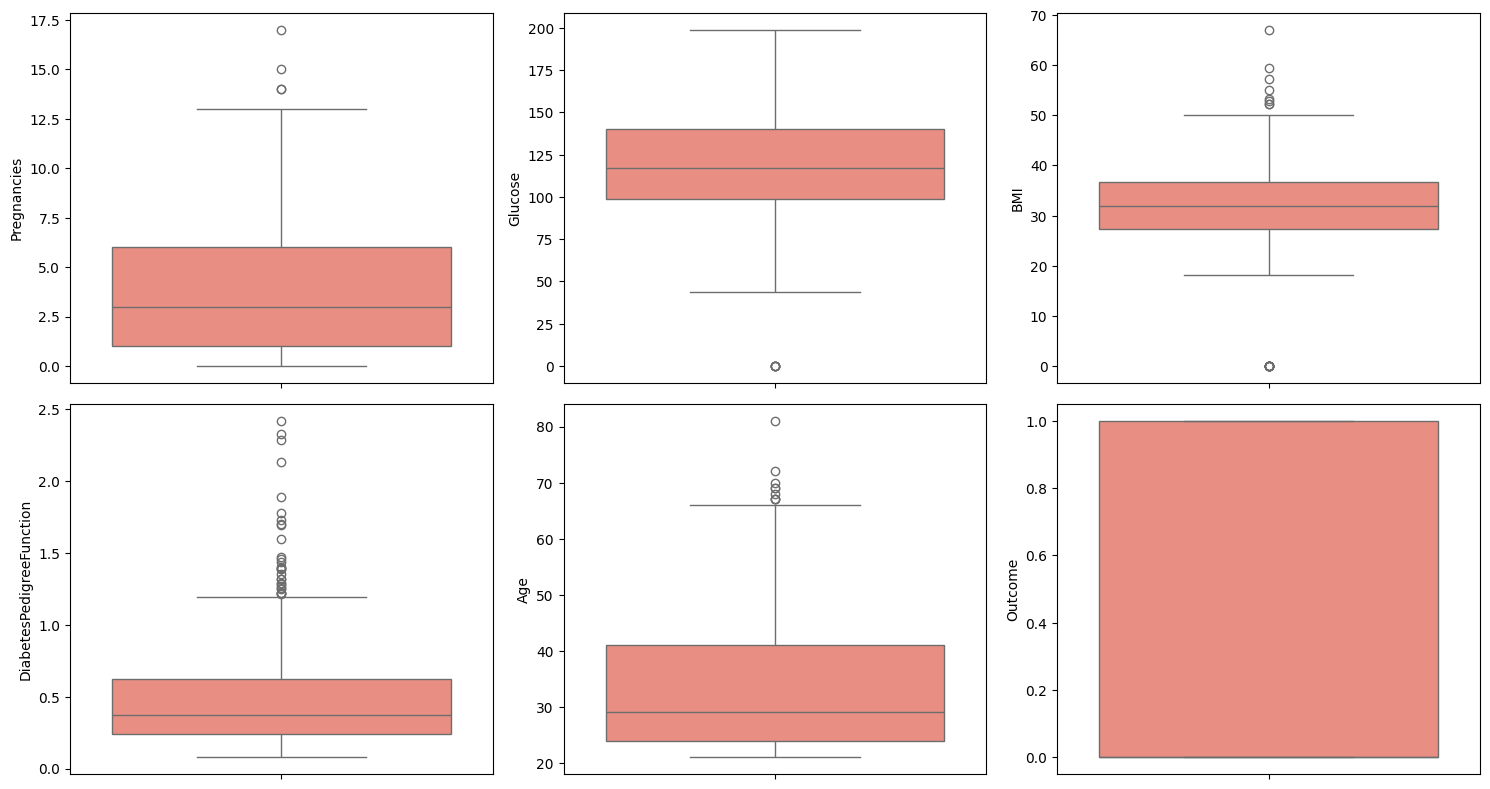

In [29]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(final_cols) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(final_cols):
    sns.boxplot(data= df, y= col, ax= axes[i], color= 'salmon')
for j in range(len(final_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
- **Critical "Zero" Errors**: The boxplots for Glucose and BMI show extreme outliers at the value of 0. As we discussed, these are biologically impossible and act as retrain points for decision tree.
- **Highly Skewed Features**: Pregnancies, Age, and DiabetesPedigreeFunction all show a heavy concentration of data at the lower end, with a significant number of high-value outliers.
- **The DiabetesPedigreeFunction** is particularly noisy, with a long string of outliers reaching up to 2.5.
- **Relatively Clean BMI**: Aside from the "0" error, the majority of BMI values are tightly clustered between 28 and 38, though there are several high-end outliers reaching above 60.
- **Outcome Distribution**: The Outcome boxplot confirms the class imbalance, showing the median and the bulk of the data (the colored box) sitting at 0, with 1 being represented as the upper limit of the distribution.

In [30]:
# Necessary coding to replace outliers creating upper and lower limits
# SAVING ALL DATASETS.

df_WITH_outliers = df.copy()
df_WITHOUT_outliers = df.copy() # This need to be modified. For every variable with outliers, I will replce outliers values.

outliers_cols = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age'] # The target variable price can't be modified so we leave as it is.

def replace_outliers(column, data_df):
   col_stats = df[column].describe()
   col_iqr = col_stats["75%"] - col_stats["25%"]
   upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
   lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

   if lower_limit < 0: lower_limit = min(df[column])
   # Let's take out upper outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
   # Let's take out lower outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
   return data_df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
   df_WITHOUT_outliers, limits = replace_outliers(column, df_WITHOUT_outliers)
   outliers_dict.update({column: limits})

outliers_dict # This jason needs to be saved

{'Pregnancies': [0, 13.5],
 'Glucose': [37.12, 202.12],
 'BMI': [13.35, 50.55],
 'DiabetesPedigreeFunction': [0.078, 1.2],
 'Age': [21, 66.5]}

In [31]:
# Saving the json dictionary for outliers limit
with open('../data/interim/outliers_dict.json', 'w') as f:
     json.dump(outliers_dict, f)

## 6.2 Missing Value Analysis

In [32]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITH outliers has any null value for the variables:
Pregnancies                 0
Glucose                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [33]:
print("The list below, will show if dataset WITHOUT outliers has any null value for the variables:")
print(df_WITHOUT_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITHOUT outliers has any null value for the variables:
Pregnancies                 0
Glucose                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [34]:
# Checking for zero's values on df_WITH_outliers
# List of columns where 0 is actually a "NaN"
cols_to_fix = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
# 1. Check for 'Hidden' missing values
# Columns where a 0 is biologically impossible
print("Zero counts per column:")
for col in cols_to_fix:
    print(f"{col}: {(df_WITH_outliers[col] == 0).sum()} zeros")

Zero counts per column:
Pregnancies: 111 zeros
Glucose: 5 zeros
BMI: 11 zeros
DiabetesPedigreeFunction: 0 zeros
Age: 0 zeros


**Numerical imputation**: To fill in the missing values or zero's in a numerical variable, normally the procedure is to use the statistical values of the sample. The most common is to import it using the mean, mode or median of that characteristic.

In [35]:
cols_to_fix = ['Glucose', 'BMI']
# Replace 0 with Nan
df[cols_to_fix] = df[cols_to_fix].replace(0, np.nan)
# Fill NaN with median and mean
df_WITH_outliers["Glucose"] = df["Glucose"].fillna(df["Glucose"].median()) # Cuando una variable es entera pero numérica/incontable
df_WITH_outliers["BMI"] = df["BMI"].fillna(df["BMI"].mean()) # Cuando una variable es puramente decimal

## 6.3 Inference of New Features
- I will test first if there is a high cirrelation rate between the three feature inference wit the target 'Outcome' and choose the higher value to keep in the analysis.
1. The Metabolic Risk Index (Glucose × BMI)
    - The heatmap showed that Glucose (0.47) and BMI (0.29) are the two strongest predictors.
2. Age-Adjusted Glucose (Glucose / Age)
    - the regression plots showed a positive correlation (0.26) between Age and Glucose.
3. Pregnancy Density (Pregnancies / Age)
    - We noticed that Age and Pregnancies have the highest internal correlation (0.54).

In [36]:
df_WITH_outliers[df_WITH_outliers['Age'] < 18]

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome


In [37]:
df_WITH_outliers['Pregnancy_Density'] = df_WITH_outliers['Pregnancies'] / (df_WITH_outliers['Age'] - 18).clip(lower=1)
df_WITHOUT_outliers['Pregnancy_Density'] = df_WITHOUT_outliers['Pregnancies'] / (df_WITHOUT_outliers['Age'] - 18).clip(lower=1)

In [38]:
df_WITH_outliers['glucose_age_ratio'] = df_WITH_outliers['Glucose'] / df_WITH_outliers['Age']
df_WITHOUT_outliers['glucose_age_ratio'] = df_WITHOUT_outliers['Glucose'] / df_WITHOUT_outliers['Age']

In [39]:
df_WITH_outliers['glucose_bmi_product'] = df_WITH_outliers['Glucose'] * df_WITH_outliers['BMI']
df_WITHOUT_outliers['glucose_bmi_product'] = df_WITHOUT_outliers['Glucose'] / df_WITHOUT_outliers['BMI']

In [40]:
print("Table with new columns added.\nWITH outliers:")
print(tabulate(df_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with new columns added.
WITH outliers:
+----+---------------+-----------+-------+----------------------------+-------+-----------+---------------------+---------------------+-----------------------+
|    |   Pregnancies |   Glucose |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |   Pregnancy_Density |   glucose_age_ratio |   glucose_bmi_product |
|----+---------------+-----------+-------+----------------------------+-------+-----------+---------------------+---------------------+-----------------------|
|  0 |             6 |       148 |  33.6 |                      0.627 |    50 |         1 |           0.1875    |             2.96    |                4972.8 |
|  1 |             1 |        85 |  26.6 |                      0.351 |    31 |         0 |           0.0769231 |             2.74194 |                2261   |
|  2 |             8 |       183 |  23.3 |                      0.672 |    32 |         1 |           0.571429  |             5.71875 |                4263

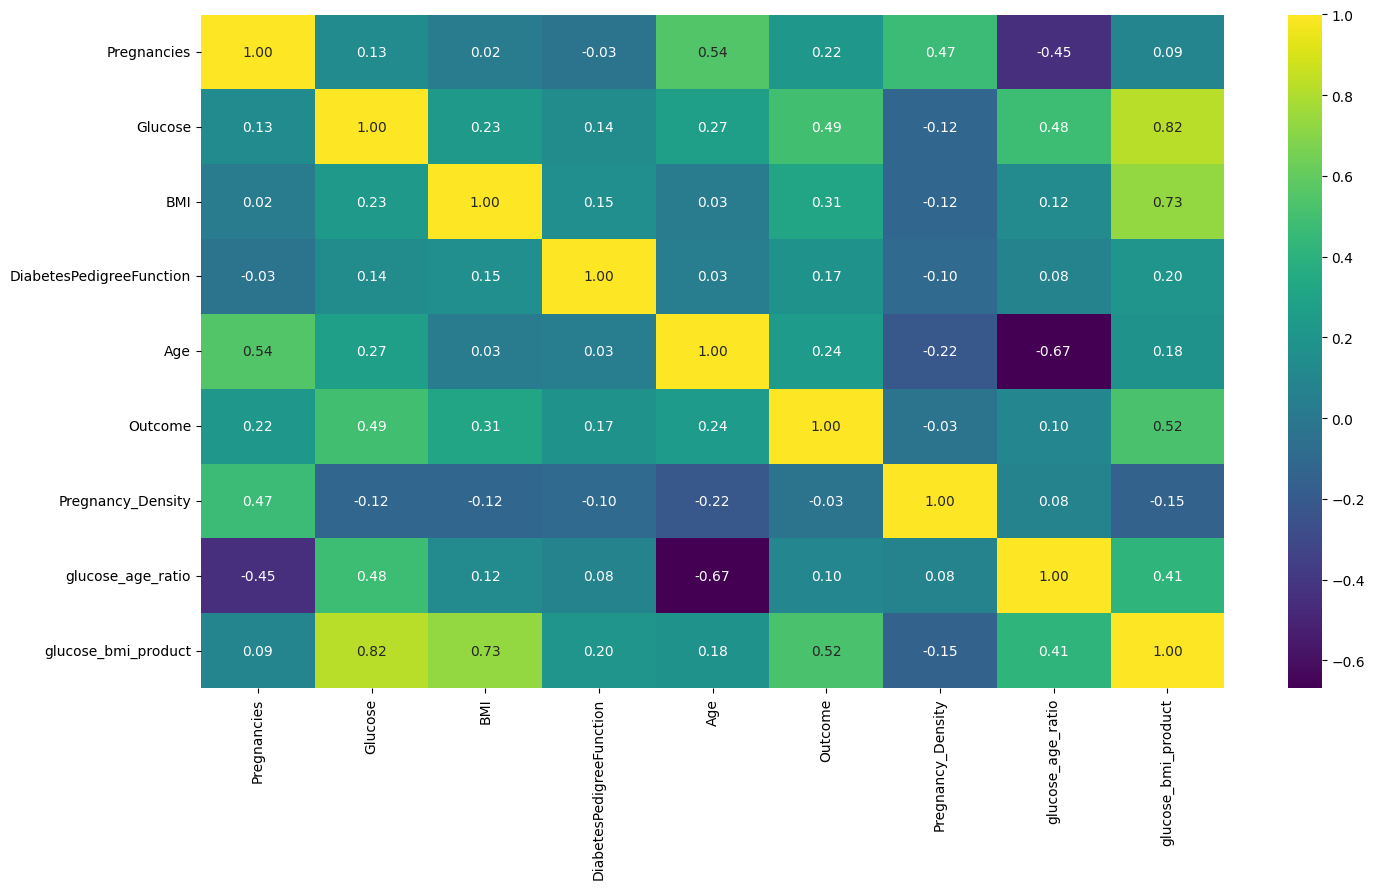

In [41]:
# Creating << NEW >> heatmap chart to analyze complete variables correlation
cols_num = df_WITH_outliers.select_dtypes(include=['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_WITH_outliers[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()

### 6.3.1 Conclusion on New Features
- **A New Feature**: The glucose_bmi_ratio shows a correlation of 0.52 with the Outcome. This is even higher than Glucose alone (0.49), making it officially the most predictive variable.
- **Feature Dominance**: This new feature is extremely highly correlated with both Glucose (0.82) and BMI (0.73).
* **Given the conclusion above**,
    - **FINAL_COL_DATSET** = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'glucose_bmi_product']


In [42]:
FINAL_COL_DATSET = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'glucose_bmi_product']
df_WITH_outliers = df_WITH_outliers[FINAL_COL_DATSET]

In [43]:
df_WITH_outliers.head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome,glucose_bmi_product
0,6,148.0,33.6,0.627,50,1,4972.8
1,1,85.0,26.6,0.351,31,0,2261.0
2,8,183.0,23.3,0.672,32,1,4263.9
3,1,89.0,28.1,0.167,21,0,2500.9
4,0,137.0,43.1,2.288,33,1,5904.7


## 6.4 Feature Scaling

In [44]:
# Divide the set into train and test
# df_WITH_outliers 
# df_WITHOUT_outliers 
				
predictors = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'glucose_bmi_product']
target = 'Outcome'

X_WITH_outliers = df_WITH_outliers.drop(target, axis = 1)[predictors]
X_WITHOUT_outliers = df_WITHOUT_outliers.drop(target, axis = 1)[predictors]
y = df_WITH_outliers[target]

X_train_WITH_outliers, X_test_WITH_outliers, y_train, y_test = train_test_split(X_WITH_outliers, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers, X_test_WITHOUT_outliers = train_test_split(X_WITHOUT_outliers, test_size = 0.2, random_state = 10)

In [45]:
# Normalization and MIN_MAX Scaling
# X_train_WITH_outliers
# X_train_WITHOUT_outliers

# X_test_WITH_outliers
# X_test_WITHOUT_outliers

# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
norm_WITH_outliers = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale. 
# .fit(), The "Learning"
norm_WITH_outliers.fit(X_train_WITH_outliers) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
X_train_WITH_outliers_norm = norm_WITH_outliers.transform(X_train_WITH_outliers) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_norm = pd.DataFrame(X_train_WITH_outliers_norm, index = X_train_WITH_outliers.index, columns = predictors) # We need to convert to DataFrame the transform with this variable

X_test_WITH_outliers_norm = norm_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_norm = pd.DataFrame(X_test_WITH_outliers_norm, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
norm_WITHOUT_outliers = StandardScaler()
norm_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_norm = pd.DataFrame(X_train_WITHOUT_outliers_norm, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_norm = pd.DataFrame(X_test_WITHOUT_outliers_norm, index = X_test_WITHOUT_outliers.index, columns = predictors)


## SCALED MIN_MAX
### WITH OUTLIERS
scaler_WITH_outliers = MinMaxScaler() # MinMaxScaler() is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_scal = scaler_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_scal = pd.DataFrame(X_train_WITH_outliers_scal, index = X_train_WITH_outliers.index, columns = predictors)

X_test_WITH_outliers_scal = scaler_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_scal = pd.DataFrame(X_test_WITH_outliers_scal, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
scaler_WITHOUT_outliers = MinMaxScaler()
scaler_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_scal = pd.DataFrame(X_train_WITHOUT_outliers_scal, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_scal = pd.DataFrame(X_test_WITHOUT_outliers_scal, index = X_test_WITHOUT_outliers.index, columns = predictors)

# X_train_WITH_outliers
# X_train_WITH_outliers_norm
# X_train_WITH_outliers_scal
# X_train_WITHOUT_outliers
# X_train_WITHOUT_outliers_norm
# X_train_WITHOUT_outliers_scal

# X_test_WITH_outliers
# X_test_WITH_outliers_norm
# X_test_WITH_outliers_scal
# X_test_WITHOUT_outliers
# X_test_WITHOUT_outliers_norm
# X_test_WITHOUT_outliers_scal

### 6.4.1 Testing Data Consistency

In [46]:
print("Table with train data modified WITH outliers.")
print(tabulate(X_train_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers.
+-----+---------------+-----------+-------+----------------------------+-------+-----------------------+
|     |   Pregnancies |   Glucose |   BMI |   DiabetesPedigreeFunction |   Age |   glucose_bmi_product |
|-----+---------------+-----------+-------+----------------------------+-------+-----------------------|
| 120 |             0 |       162 |  53.2 |                      0.759 |    25 |                8618.4 |
| 172 |             2 |        87 |  28.9 |                      0.773 |    25 |                2514.3 |
| 307 |             0 |       137 |  24.8 |                      0.143 |    21 |                3397.6 |
|   7 |            10 |       115 |  35.3 |                      0.134 |    29 |                4059.5 |
| 448 |             0 |       104 |  33.6 |                      0.51  |    22 |                3494.4 |
+-----+---------------+-----------+-------+----------------------------+-------+-----------------------+


In [47]:
print("Table with train data modified WITH outliers. Normalization of the data embedded.")
print(tabulate(X_train_WITH_outliers_norm.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers. Normalization of the data embedded.
+-----+---------------+-----------+-----------+----------------------------+-----------+-----------------------+
|     |   Pregnancies |   Glucose |       BMI |   DiabetesPedigreeFunction |       Age |   glucose_bmi_product |
|-----+---------------+-----------+-----------+----------------------------+-----------+-----------------------|
| 120 |      -1.13284 |  1.27958  |  3.06838  |                   0.907497 | -0.698457 |              3.1143   |
| 172 |      -0.54213 | -1.12757  | -0.495196 |                   0.950374 | -0.698457 |             -0.9951   |
| 307 |      -1.13284 |  0.477196 | -1.09646  |                  -0.979075 | -1.03882  |             -0.400445 |
|   7 |       1.82073 | -0.228901 |  0.443359 |                  -1.00664  | -0.358098 |              0.045159 |
| 448 |      -1.13284 | -0.58195  |  0.194055 |                   0.144906 | -0.953727 |             -0.335277 |
+-----+-------

### 6.4.2 Saving all of the DATASET
    train, test with all the variance we have created.

In [48]:
# DATASETS that have been created so far in previous steps from the feature engineering

X_train_WITH_outliers.to_excel("../data/processed/X_train_WITH_outliers.xlsx", index = False)
X_train_WITH_outliers_norm.to_excel("../data/processed/X_train_WITH_outliers_norm.xlsx", index = False)
X_train_WITH_outliers_scal.to_excel("../data/processed/X_train_WITH_outliers_scal.xlsx", index = False)
X_train_WITHOUT_outliers.to_excel("../data/processed/X_train_WITHOUT_outliers.xlsx", index = False)
X_train_WITHOUT_outliers_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx", index = False)
X_train_WITHOUT_outliers_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx", index = False)

X_test_WITH_outliers.to_excel("../data/processed/X_test_WITH_outliers.xlsx", index = False)
X_test_WITH_outliers_norm.to_excel("../data/processed/X_test_WITH_outliers_norm.xlsx", index = False)
X_test_WITH_outliers_scal.to_excel("../data/processed/X_test_WITH_outliers_scal.xlsx", index = False)
X_test_WITHOUT_outliers.to_excel("../data/processed/X_test_WITHOUT_outliers.xlsx", index = False)
X_test_WITHOUT_outliers_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_norm.xlsx", index = False)
X_test_WITHOUT_outliers_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers, file)
with open("../models/norm_WITHOUT_outliers.pkl", "wb") as file:
   pickle.dump(norm_WITHOUT_outliers, file)
with open("../models/scaler_WITH_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers, file)
with open("../models/scaler_WITHOUT_outliers.pkl", "wb") as file:
   pickle.dump(scaler_WITHOUT_outliers, file)

# Step 7. Feature Selection
    - Test all dataset "roughly" and I will keep the best score. Keeping all variable.
    - The model need to be trained entirely.
    - If results meet desire objective --> YEAH! WE?VE FINISHED.
    - If not, move back to step 6 and repeat the process from step 2.

In [49]:
# sklearn: professional-grade "toolbox" that provides a consistent way to build, test, and deploy predictive models.
# f_classif: is a function that performs a statistical test called ANOVA (Analysis of Variance).
# SelectKBest: While f_classif does the math, SelectKBest is the "manager" that acts on those numbers.
 

X_train = X_train_WITH_outliers.copy()
X_test = X_test_WITH_outliers.copy()

# With k = 5, We tell it to use f_classif as the scorer and pick the top 5 features, to avoid "overwhelming" the model
selection_model = SelectKBest(score_func=f_regression, k = 5)
selection_model.fit(X_train, y_train)

# .get_support(), This returns a list of "True/False" values (e.g., [True, False, True...]). This is how one "remember" which column names were the winners.
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print("Table with the top 5 columns slected for the Machine Learning model.")
print(tabulate(X_train_sel.head(), headers= "keys", tablefmt= "psql"))

Table with the top 5 columns slected for the Machine Learning model.
+----+---------------+-----------+-------+-------+-----------------------+
|    |   Pregnancies |   Glucose |   BMI |   Age |   glucose_bmi_product |
|----+---------------+-----------+-------+-------+-----------------------|
|  0 |             0 |       162 |  53.2 |    25 |                8618.4 |
|  1 |             2 |        87 |  28.9 |    25 |                2514.3 |
|  2 |             0 |       137 |  24.8 |    21 |                3397.6 |
|  3 |            10 |       115 |  35.3 |    29 |                4059.5 |
|  4 |             0 |       104 |  33.6 |    22 |                3494.4 |
+----+---------------+-----------+-------+-------+-----------------------+


In [50]:
X_test_sel.head()

,Pregnancies,Glucose,BMI,Age,glucose_bmi_product
0,4.0,154.0,31.3,37.0,4820.2
1,2.0,112.0,38.4,28.0,4300.8
2,1.0,135.0,26.7,62.0,3604.5
3,3.0,107.0,22.9,23.0,2450.3
4,3.0,102.0,29.5,32.0,3009.0


## 7.2 Check the Winners Column
It is very helpful to see which 5 columns were chosen and how much better they are than the ones that were dropped.

In [51]:
# Create a small table of the scores
features_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selection_model.scores_
}).sort_values(by='Score', ascending=False)

print("Table that shows the score used in order to select the top 4 columns for ML model")
print(tabulate(features_scores, headers= "keys", tablefmt= "psql"))

Table that shows the score used in order to select the top 4 columns for ML model
+----+--------------------------+----------+
|    | Feature                  |    Score |
|----+--------------------------+----------|
|  5 | glucose_bmi_product      | 210.506  |
|  1 | Glucose                  | 204.243  |
|  2 | BMI                      |  53.3795 |
|  4 | Age                      |  50.5489 |
|  0 | Pregnancies              |  32.5559 |
|  3 | DiabetesPedigreeFunction |  15.5777 |
+----+--------------------------+----------+


In [52]:
# Create a dataframe to compare scores and p-values
feature_stats = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': selection_model.scores_,
    'p-value': selection_model.pvalues_
})

# Format p-values to be readable (avoiding scientific notation like 1e-10)
feature_stats['p-value'] = feature_stats['p-value'].apply(lambda x: format(x, '.5f'))

print("Table adding extra information on p-values. It represents the probability - relationship between variables.")
print(tabulate(feature_stats.sort_values(by='F-Score', ascending=False), headers= "keys", tablefmt= "psql"))

Table adding extra information on p-values. It represents the probability - relationship between variables.
+----+--------------------------+-----------+-----------+
|    | Feature                  |   F-Score |   p-value |
|----+--------------------------+-----------+-----------|
|  5 | glucose_bmi_product      |  210.506  |     0     |
|  1 | Glucose                  |  204.243  |     0     |
|  2 | BMI                      |   53.3795 |     0     |
|  4 | Age                      |   50.5489 |     0     |
|  0 | Pregnancies              |   32.5559 |     0     |
|  3 | DiabetesPedigreeFunction |   15.5777 |     9e-05 |
+----+--------------------------+-----------+-----------+


# Step 8. Best Model Selection
## 8.1 Reading the Processed Dataset

In [53]:
# We will use the train set to train the model.

X_train_WITH_outliers = pd.read_excel("../data/processed/X_train_WITH_outliers.xlsx")
X_train_WITH_outliers_norm = pd.read_excel("../data/processed/X_train_WITH_outliers_norm.xlsx")
X_train_WITH_outliers_scal = pd.read_excel("../data/processed/X_train_WITH_outliers_scal.xlsx")
X_train_WITHOUT_outliers = pd.read_excel("../data/processed/X_train_WITHOUT_outliers.xlsx")
X_train_WITHOUT_outliers_norm = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx")
X_train_WITHOUT_outliers_scal = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx")
y_train = pd.read_excel("../data/processed/y_train.xlsx")

In [54]:
datasets = [
    X_train_WITH_outliers,
    X_train_WITH_outliers_norm,
    X_train_WITH_outliers_scal,
    X_train_WITHOUT_outliers,
    X_train_WITHOUT_outliers_norm,
    X_train_WITHOUT_outliers_scal
    ]

models = []
metrics = []
for dataset in datasets:
  model = DecisionTreeClassifier(random_state = 10) # Decision Tree
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = accuracy_score(y_train, y_pred)
  metrics.append(metric)
  models.append(model)

best_metric = max(metrics)
best_index = metrics.index(best_metric)
print(f"This is the list of accu. score: {metrics}\nThe best metric: {best_metric}\nThe Best index: {best_index}")
print("The best DataSet is: ", datasets[best_index])

This is the list of accu. score: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
The best metric: 1.0
The Best index: 0
The best DataSet is:       Pregnancies  Glucose   BMI  DiabetesPedigreeFunction  Age  \
0              0      162  53.2                     0.759   25   
1              2       87  28.9                     0.773   25   
2              0      137  24.8                     0.143   21   
3             10      115  35.3                     0.134   29   
4              0      104  33.6                     0.510   22   
..           ...      ...   ...                       ...  ...   
609            1      133  32.8                     0.234   45   
610            4      129  27.5                     0.527   31   
611            3      116  26.3                     0.107   24   
612            1       88  55.0                     0.496   26   
613            5       96  33.6                     0.997   43   

     glucose_bmi_product  
0                 8618.4  
1                 2514.3  
2

### For the above result of the scoring having all of then just 1s, it might be a Overfitting and Metric Incompatibility.

## 8.2 Initialization and Training of the Model
    - In this case, I will use the test data set to avoid any overfiting for the decision tree model

In [55]:
# We need the test sets ready to properly evaluate decision tree
test_datasets = [
    X_test_WITH_outliers, X_test_WITH_outliers_norm, X_test_WITH_outliers_scal,
    X_test_WITHOUT_outliers, X_test_WITHOUT_outliers_norm, X_test_WITHOUT_outliers_scal
]
models = []
metrics = []
for i, dataset in enumerate(datasets):
    # Set max_depth to prevent the model from memorizing the data
    model = DecisionTreeClassifier(random_state=10) 
    model.fit(dataset, y_train)
    
    # CRITICAL: Predict on the TEST set, not the training dataset
    y_test_pred = model.predict(test_datasets[i])
    
    # Use Accuracy Score for classification
    metric = accuracy_score(y_test, y_test_pred)
    
    metrics.append(metric)
    models.append(model)

best_metric = max(metrics)
best_index = metrics.index(best_metric)

print(f"Test Set Accuracy Scores: {metrics}")
print(f"Best Dataset Index: {best_index} (Score: {best_metric:.4f})")

Test Set Accuracy Scores: [0.6623376623376623, 0.6558441558441559, 0.6558441558441559, 0.6688311688311688, 0.6623376623376623, 0.6688311688311688]
Best Dataset Index: 3 (Score: 0.6688)


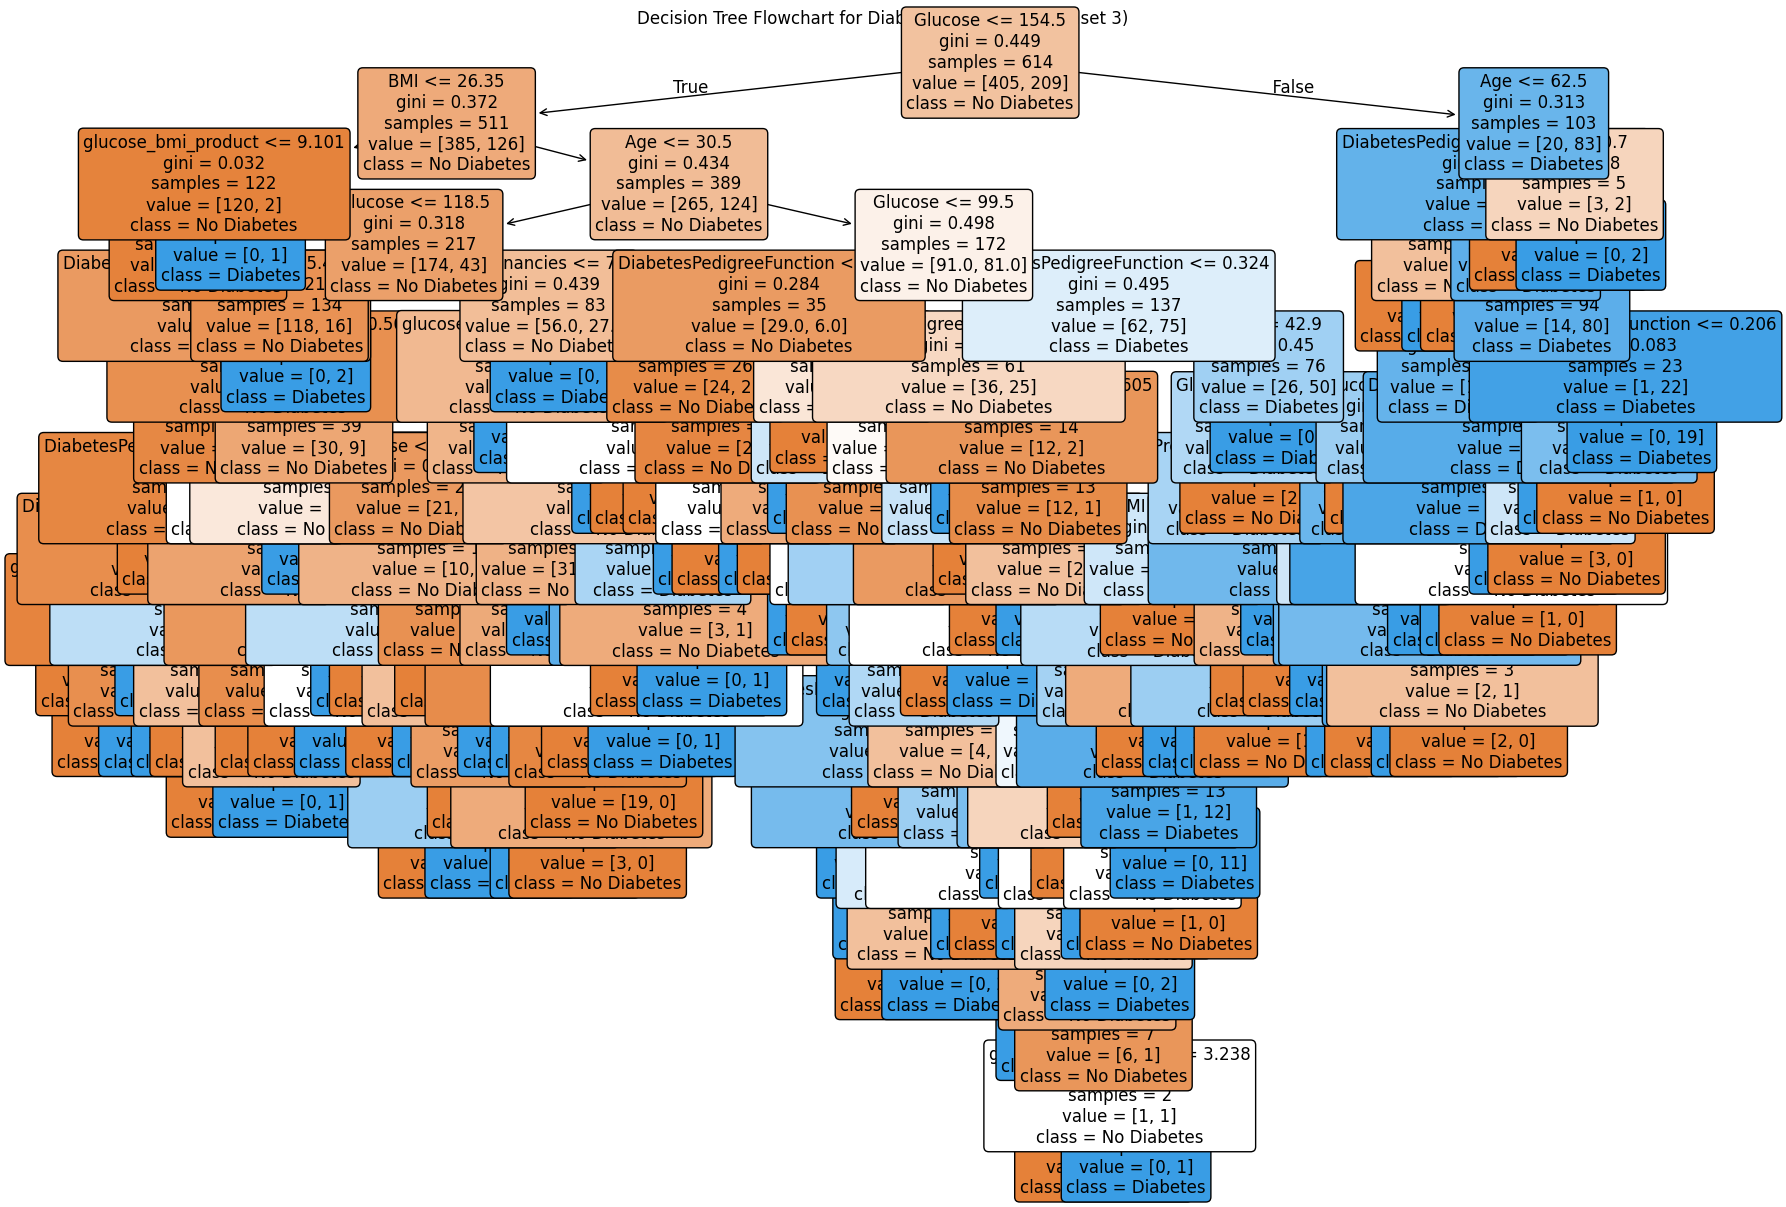

In [56]:
# 1. Train the model on your best dataset (Index 3)
best_model = DecisionTreeClassifier(random_state=10)
best_model.fit(X_train_WITHOUT_outliers, y_train)

# 2. Plot the tree
plt.figure(figsize=(20,15))
plot_tree(best_model, 
          feature_names=X_train_WITHOUT_outliers.columns, 
          class_names=['No Diabetes', 'Diabetes'], 
          filled=True, 
          rounded=True, 
          fontsize=12)
plt.title("Decision Tree Flowchart for Diabetes Prediction (Dataset 3)")
plt.show()

### 8.2.1 This first Decision Tree
    - It looks very messy and there were not hiperparameterization applied on purpose to understand the behavior of the model visualization at first glance

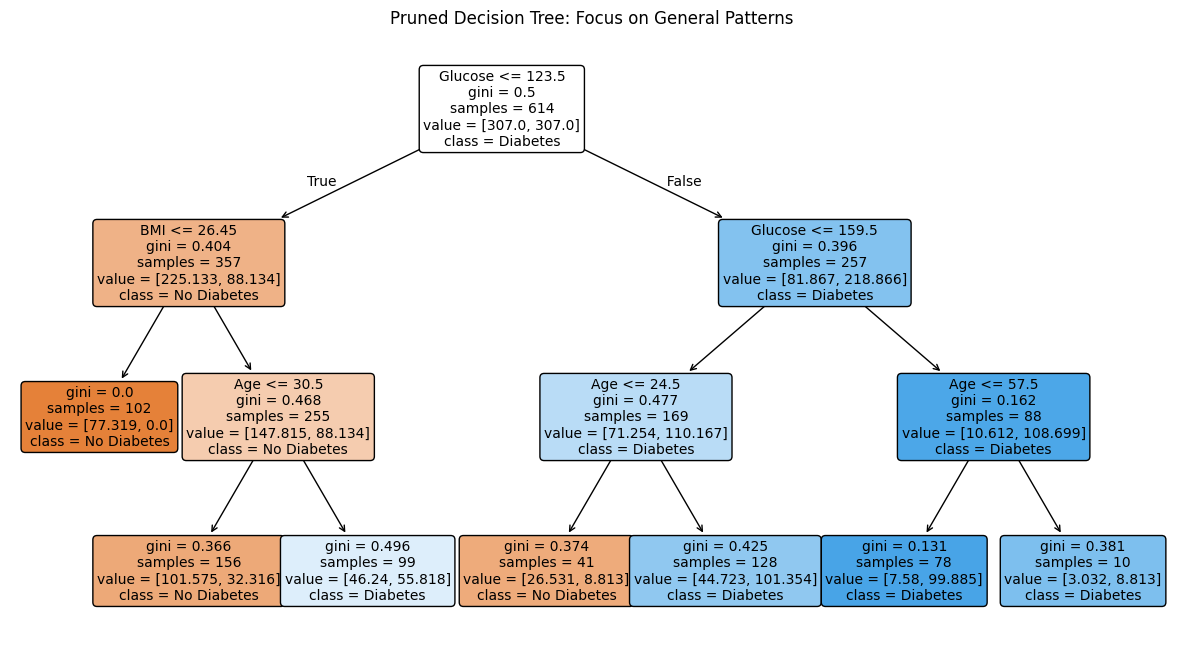

In [57]:
# Prune Tree visualization and create a << clean_model >> using hiperparameterization

# We limit the depth and require at least 10 people in a box to make a rule
clean_model = DecisionTreeClassifier(max_depth= 3, min_samples_leaf= 10, 
                                     class_weight= 'balanced', random_state=10)
clean_model.fit(X_train_WITHOUT_outliers, y_train)

plt.figure(figsize=(15,8))
plot_tree(clean_model, 
          feature_names=X_train_WITHOUT_outliers.columns, 
          class_names=['No Diabetes', 'Diabetes'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Pruned Decision Tree: Focus on General Patterns")
plt.show()

### 8.2.2 Conclusion Decision Tree Pruned
- The model autonomously identified Glucose level 123.5 as the primary threshold for risk in this population. It didn't just guess; it mathematically optimized the split to maximize the separation between healthy and diabetic patients".

In [58]:
# Create a DataFrame for easier reading
importance_df = pd.DataFrame({
    'Feature': X_train_WITHOUT_outliers.columns,
    'Importance': clean_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("--- FEATURE IMPORTANCE (PRUNED MODEL) ---")
print(importance_df)

--- FEATURE IMPORTANCE (PRUNED MODEL) ---
                    Feature  Importance
1                   Glucose    0.655977
4                       Age    0.200837
2                       BMI    0.143186
0               Pregnancies    0.000000
3  DiabetesPedigreeFunction    0.000000
5       glucose_bmi_product    0.000000


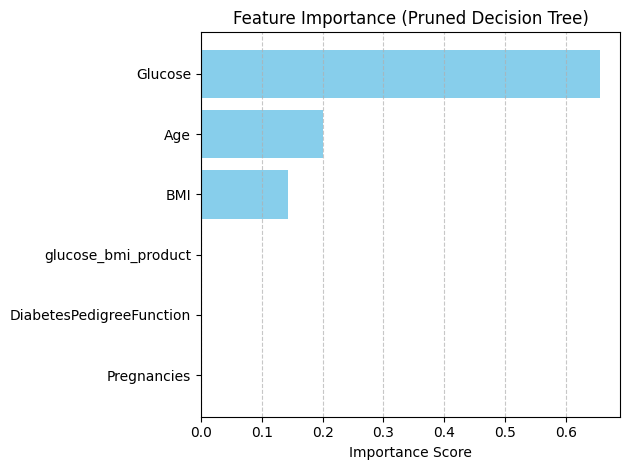

In [59]:
data = {
    'Feature': ['Glucose', 'Age', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction', 'glucose_bmi_product'],
    'Importance': importance_df['Importance']
}

df = pd.DataFrame(data).sort_values(by='Importance', ascending=True)

plt.barh(df['Feature'], df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance (Pruned Decision Tree)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('feature_importance.png')

### 8.2.3 Concusion on Feature Importance table
- **Glucose is King (65.6%)**: The model relies on Glucose for more than half of its decision. Glucose was the very first question asked.
- **The Power Trio**: Glucose, Age, and BMI are the only features the model is using. Together, they make up 100% of the importance.
- **The 0.0 Scores**: Features like Pregnancies and DiabetesPedigreeFunction have a score of 0.0. It could mean that within a depth of 3 layers, the model found that Glucose, Age, and BMI provided much stronger medical evidence.
- **glucose_bmi_product**: Funny how ML works! While my engineered feature showed promise in the complex model, the pruned, more reliable model favored raw Glucose and Age to ensure the rules were simple enough.

## 8.3 Confusion Matrix for the Pruned Model

<Figure size 800x600 with 0 Axes>

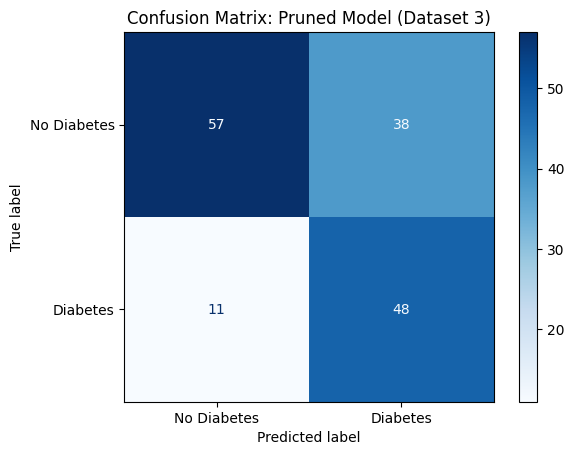

In [60]:
# 1. Get predictions from the cleaned model on the best test set
y_test_pred = clean_model.predict(X_test_WITHOUT_outliers)

# 2. Create the matrix
cm = confusion_matrix(y_test, y_test_pred)

# 3. Plot it beautifully
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap= 'Blues', values_format= 'd')
plt.title("Confusion Matrix: Pruned Model (Dataset 3)")
plt.show()

In [61]:
# Use the same predictions we used for the confusion matrix
report = classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes'])

print("--- FINAL MODEL PERFORMANCE REPORT ---")
print(report)

--- FINAL MODEL PERFORMANCE REPORT ---
              precision    recall  f1-score   support

 No Diabetes       0.84      0.60      0.70        95
    Diabetes       0.56      0.81      0.66        59

    accuracy                           0.68       154
   macro avg       0.70      0.71      0.68       154
weighted avg       0.73      0.68      0.69       154



### 8.3.1 Final Conclusion Confusion Matrix
- Total number of patients in this test set is 154 ($57+38+11+48$)
- **True Positives (48)**: Successfully identified 48 people who actually have diabetes.
- **True Negatives (57)**: Correctly identified 57 healthy people.
- **False Positives (38)**: The model showed 38 healthy people as having diabetes.
- **False Negatives (11)**: This is the most important number. The analysis only missed 11 people who actually had the disease.
- **Accuracy** ~68%	The overall percentage of correct guesses (Healthy + Diabetic).
- ++Recall** (Sensitivity) 81.3% The Safety Score: How many diabetic patients were successfully caught (48 out of 59).
- **Precision**	~56% The Reliability Score: When the model says "Diabetes," how often it is actually right.
- **F1-Score** ~66%	The balanced "Grade" of the model considering both misses and false alarms.

In [64]:
# Saving the 'clean_model' which has the 81% Recall
filename = '../models/diabetes_pruned_model_depth3_rs10.sav'
pickle.dump(clean_model, open(filename, 'wb'))

print(f"Model successfully saved as {filename}")

Model successfully saved as ../models/diabetes_pruned_model_depth3_rs10.sav
